# DSP 562 Final Project: Educational Equity through Clustering and Fairness Analysis
Author: Abi Kambanis

This notebook implements a two-phase analysis:
1. Clustering student pathways
2. Auditing equity across identified clusters

In [ ]:
# A. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# B. Load Dataset
from google.colab import drive
# Mount Google Drive.
drive.mount('/content/drive')

# Print the first five rows of the dataset
df = pd.read_csv('/content/drive/MyDrive/predict_students.csv', sep=';')

# Strip whitespace, tabs, and replace spaces and slashes
df.columns = (
    df.columns
    .str.strip()
    .str.replace(r'\\t', '', regex=True)
    .str.replace('/', '_')
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.lower()
)

df.head()

Mounted at /content/drive


,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother's_qualification,father's_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [ ]:
# C1. Feature Engineering & Cleaning

# Rename columns for clarity
df = df.rename(columns={
    'curricular_units_1st_sem_approved': 'units_approved_sem1',
    'curricular_units_1st_sem_enrolled': 'units_enrolled_sem1',
    'curricular_units_2nd_sem_approved': 'units_approved_sem2',
    'curricular_units_2nd_sem_enrolled': 'units_enrolled_sem2',
    'tuition_fees_up_to_date': 'tuition_up_to_date',
    'debtor': 'has_debt',
    'target': 'final_situation'
})

# Feature 1: Success Rate (Semester 1)
df['success_rate_sem1'] = df['units_approved_sem1'] / df['units_enrolled_sem1']
df['success_rate_sem1'] = df['success_rate_sem1'].fillna(0)  # Handle division by zero

# Feature 2: Combined debt flag
df['debt_flag'] = ((df['has_debt'] == 1) | (df['tuition_up_to_date'] == 0)).astype(int)

# Feature 3: Age binning for equity views
df['age_bin'] = pd.cut(df['age_at_enrollment'], bins=[15, 20, 25, 30, 35, 50],
                       labels=['16–20', '21–25', '26–30', '31–35', '36+'])

# Preview new features
df[['success_rate_sem1', 'debt_flag', 'age_bin']].head()


,success_rate_sem1,debt_flag,age_bin
0,0.000000,0,16–20
1,1.000000,1,16–20
2,0.000000,1,16–20
3,1.000000,0,16–20
4,0.833333,0,36+


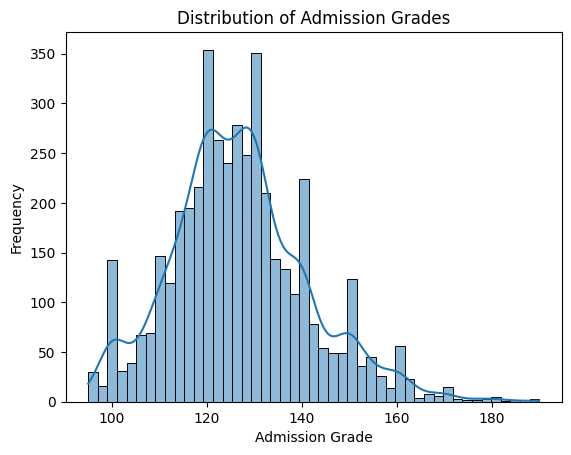

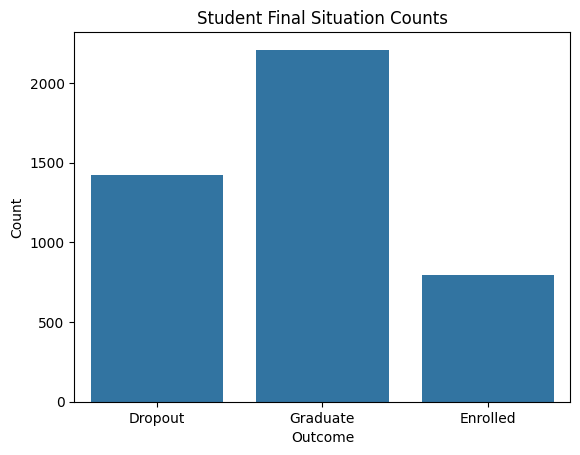

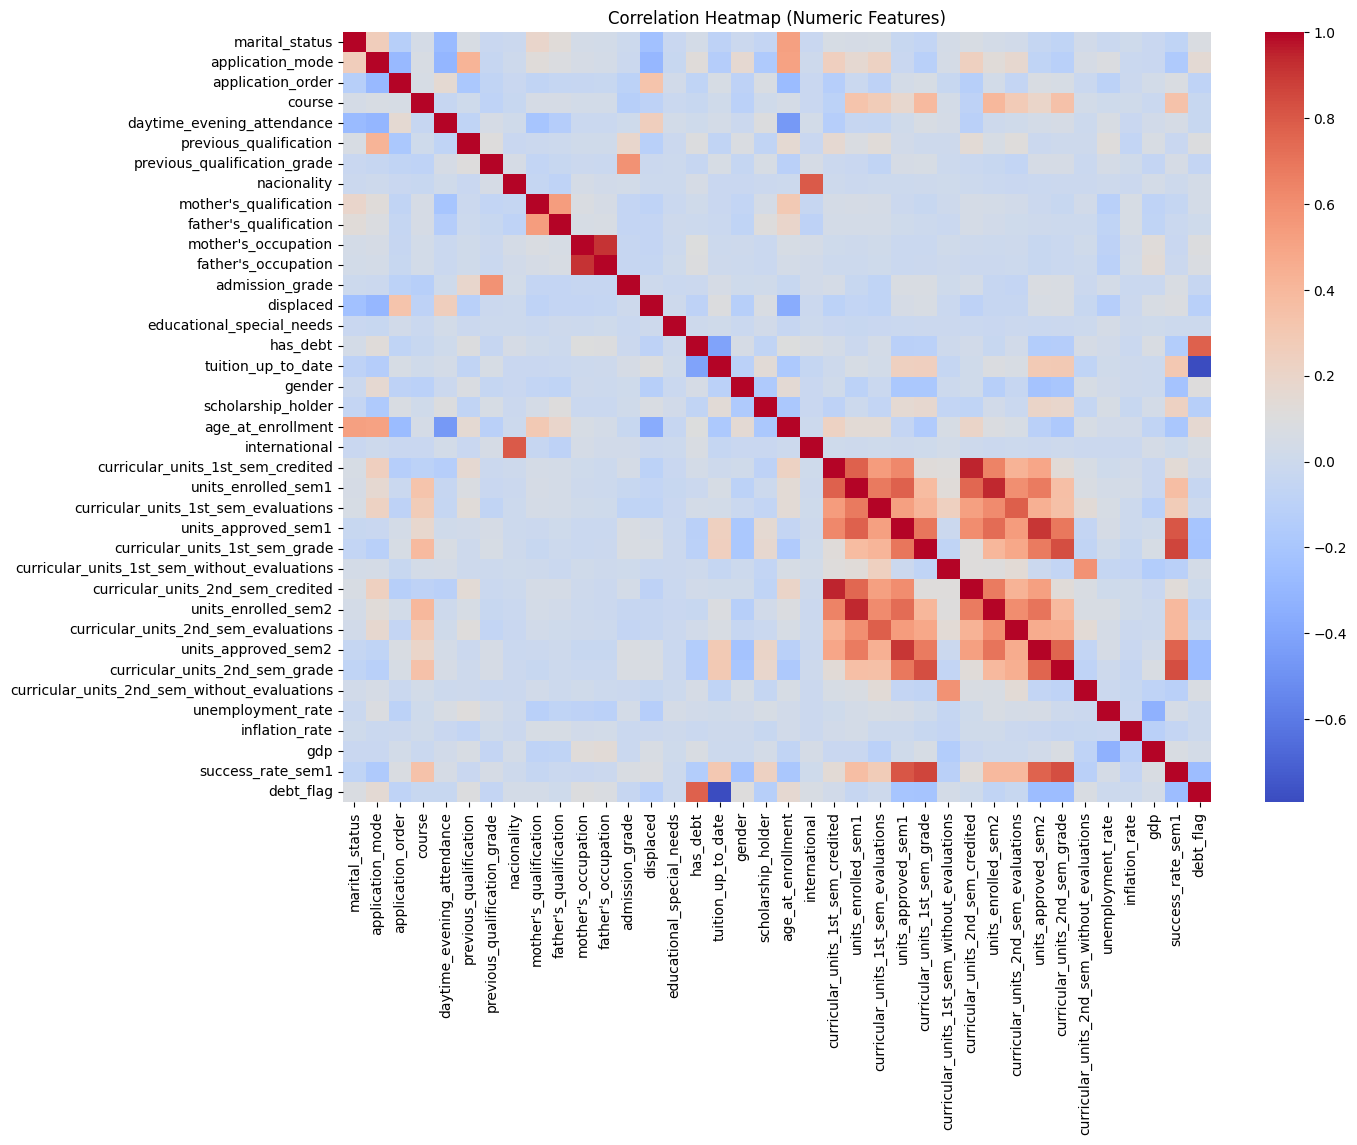

In [ ]:
# C2. Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of admission grades
sns.histplot(df['admission_grade'], kde=True)
plt.title('Distribution of Admission Grades')
plt.xlabel('Admission Grade')
plt.ylabel('Frequency')
plt.show()

# 2. Final situation count (dropout vs enrolled vs graduated)
sns.countplot(data=df, x='final_situation')
plt.title('Student Final Situation Counts')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

# 3. Correlation heatmap of numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

##C2. Exploratory Data Analysis (EDA)
Admission Grade Distribution
The distribution of students’ admission grades shows a slightly right-skewed pattern, with the majority of students scoring between 110 and 140 out of 200. There is a peak in the low- to mid-120s, suggesting that most students are admitted with average academic performance. A few students are admitted with higher scores (160+), but these are relatively rare.
<br>
<br>


**Final Student Situations**
Out of 4,424 students:

- Graduates form the largest group, with over 2,000 students successfully completing their programs.

- Dropouts represent a significant portion of the population, close to 1,400 students.

- Enrolled students account for the smallest group, indicating those still progressing or paused.

This distribution underscores the relevance of this project’s focus on identifying at-risk students and understanding the demographic and academic profiles behind different outcomes.
<br>
<br>

### **Correlation Heatmap**
<br>
The correlation heatmap of numeric features shows several strong relationships:

- High correlations are observed within academic performance variables, especially between enrolled, evaluated, and approved units in the same semester. This is expected and highlights potential redundancy.

- Success rate (sem1) is positively correlated with approval and grade metrics, affirming its value as a synthesized performance feature.

- Debt-related variables appear to have limited correlation with academic performance, but their fairness impact may emerge more clearly in equity analysis.

- External macro indicators (e.g., GDP, unemployment) show little correlation with individual academic features, suggesting they may be excluded from clustering unless explicitly analyzed in a policy context.

These insights will inform feature selection for clustering by helping reduce multicollinearity and focus on the most informative features across demographic, academic, and socioeconomic domains.



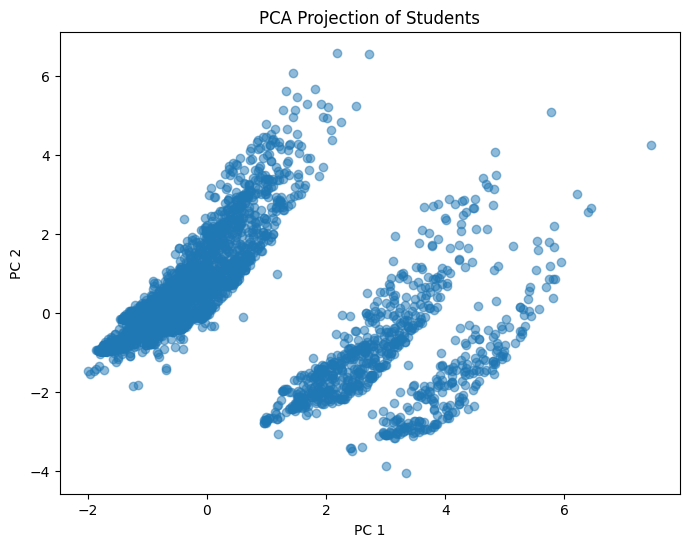

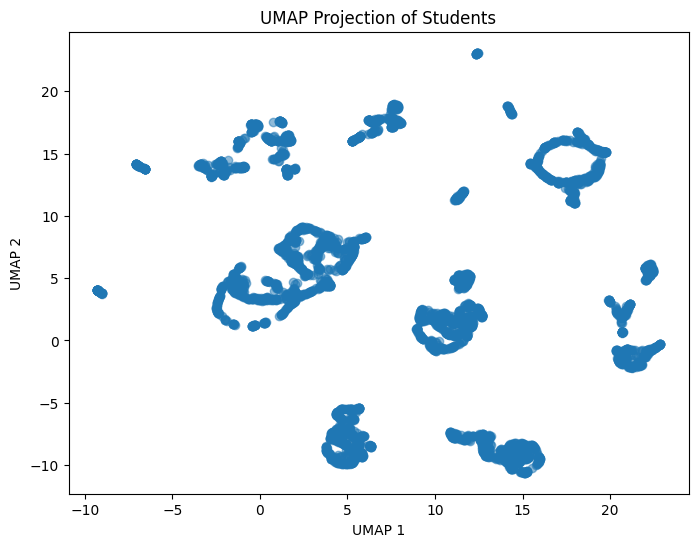

In [ ]:
# C3. Feature Selection for Clustering (Next Step Placeholder)

# We will select a subset of meaningful features for PCA/UMAP and clustering.
# This will be done based on the correlation matrix, distributions, and project goals.

# Step 1: Select Features Based on Goals and Correlation
selected_features = [
    'admission_grade',
    'age_at_enrollment',
    'gender',
    'nacionality', # Corrected column name
    'marital_status',
    'scholarship_holder',
    'has_debt',
    'tuition_up_to_date',
    'success_rate_sem1',
    'debt_flag',
    'educational_special_needs',
    'displaced'
]


# Step 2: Preprocess for Clustering (Encoding + Scaling)
from sklearn.preprocessing import StandardScaler

# Make a copy of selected data
X = df[selected_features].copy()

# Encode categorical variables (binary → 0/1; others → one-hot)
X = pd.get_dummies(X, drop_first=True)

# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Step 3: Apply PCA and/or UMAP
from sklearn.decomposition import PCA
import umap.umap_ as umap

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)


# Step 4: Visualize Dimensionality Reduction
# PCA Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection of Students')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# UMAP Plot
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title('UMAP Projection of Students')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

##C3. Feature Selection & Dimensionality Reduction
To prepare the dataset for clustering, a curated subset of features was selected to represent students' academic performance, demographics, and socioeconomic status while avoiding redundancy and overfitting. Features were chosen based on domain relevance, correlation heatmap insights, and clustering suitability. These included:

- Academic indicator: admission_grade, success_rate_sem1

- Demographic information: age_at_enrollment, gender, marital_status, nationality

- Socioeconomic variables: scholarship_holder, has_debt, tuition_up_to_date, displaced, educational_special_needs

- Engineered feature: debt_flag (combining has_debt and tuition_up_to_date)

Categorical features were encoded, and all numeric features were standardized using StandardScaler to ensure that clustering algorithms would not be biased by differences in scale.
<br>
<br>

### **PCA Projection**

Principal Component Analysis (PCA) was applied to reduce the high-dimensional feature space to two principal components. The PCA scatter plot shows a moderate spread of data along the first component, with no immediately obvious distinct clusters. This suggests the student data contains overlapping groupings that may not be linearly separable.

The PCA plot reveals a visually stratified distribution of students across three prominent bands along the first principal component (PC1). This pattern suggests that a few dominant linear relationships, likely related to academic performance or age—are driving a significant portion of the variance in the dataset. Within each band, the spread along PC2 captures some additional variation, though the structure is more diffuse. Importantly, PCA imposes linear constraints, which may oversimplify or obscure more subtle groupings in the student profiles. While helpful for understanding high-level variance, PCA appears to compress much of the nuance necessary for equity-driven clustering.
<br>
<br>

### **UMAP Projection**

Uniform Manifold Approximation and Projection (UMAP) was also applied to preserve both global and local data structures. The UMAP 2D plot reveals a more nuanced separation of students, with several moderately dense regions and visible gradients of distribution. These emerging patterns are promising for downstream clustering, as UMAP is better suited for capturing nonlinear structure in high-dimensional educational data.

In contrast, the UMAP projection uncovers highly nonlinear and well-separated clusters in the data. Roughly 10–12 dense, clearly segmented regions emerge, some forming ring-like or tightly packed clusters. This suggests strong local structure and meaningful subgroupings in the data. The separation observed here implies that clustering algorithms may perform well, particularly KMeans or DBSCAN, given UMAP’s preservation of both local and global structures. These patterns hint at diverse student pathways, possibly shaped by a combination of academic, financial, and demographic variables.
<br>
<br>

### **Selection of Primary Method**

UMAP is thus selected as the primary method for cluster validation and visualization, given its superior ability to reveal interpretable structure that aligns with the project’s goal of identifying distinct educational experiences and equity implications.

Overall, UMAP is selected as the preferred projection method for visualizing and validating cluster separability, while the full scaled feature matrix will be used for algorithmic clustering.



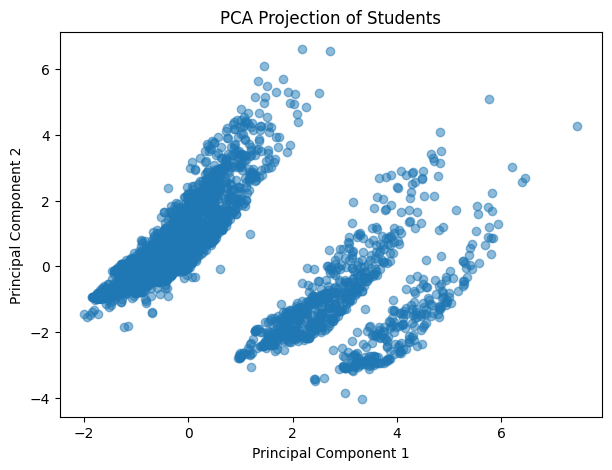

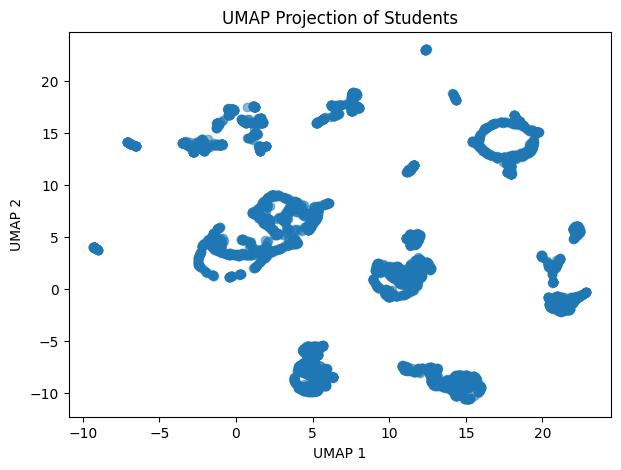

In [ ]:
# D. Dimensionality Reduction

from sklearn.decomposition import PCA
import umap.umap_ as umap

# PCA for variance analysis (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP for cluster visualization
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Visualize PCA
plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection of Students')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize UMAP
plt.figure(figsize=(7, 5))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title('UMAP Projection of Students')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


k=2, silhouette score=0.3634
k=3, silhouette score=0.1903
k=4, silhouette score=0.2018
k=5, silhouette score=0.2159
k=6, silhouette score=0.2435
k=7, silhouette score=0.2263
k=8, silhouette score=0.2661
k=9, silhouette score=0.2591

Best number of clusters by silhouette score: k = 2


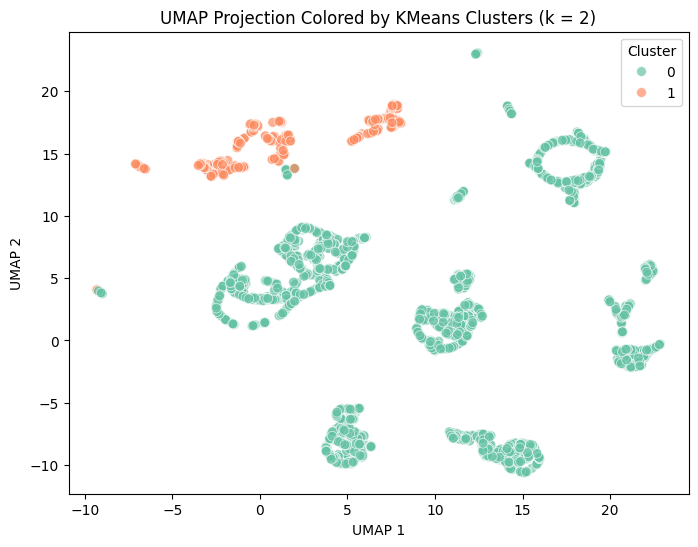

In [ ]:
# E. Clustering and Validation

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try multiple k values and print silhouette scores
silhouette_scores = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores[k] = score
    print(f"k={k}, silhouette score={score:.4f}")

# Choose best k (e.g., highest silhouette score)
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nBest number of clusters by silhouette score: k = {best_k}")

# Fit final KMeans model
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = final_kmeans.fit_predict(X_scaled)

# Visualize UMAP with cluster coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster'], palette='Set2', s=50, alpha=0.7)
plt.title(f"UMAP Projection Colored by KMeans Clusters (k = {best_k})")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.show()

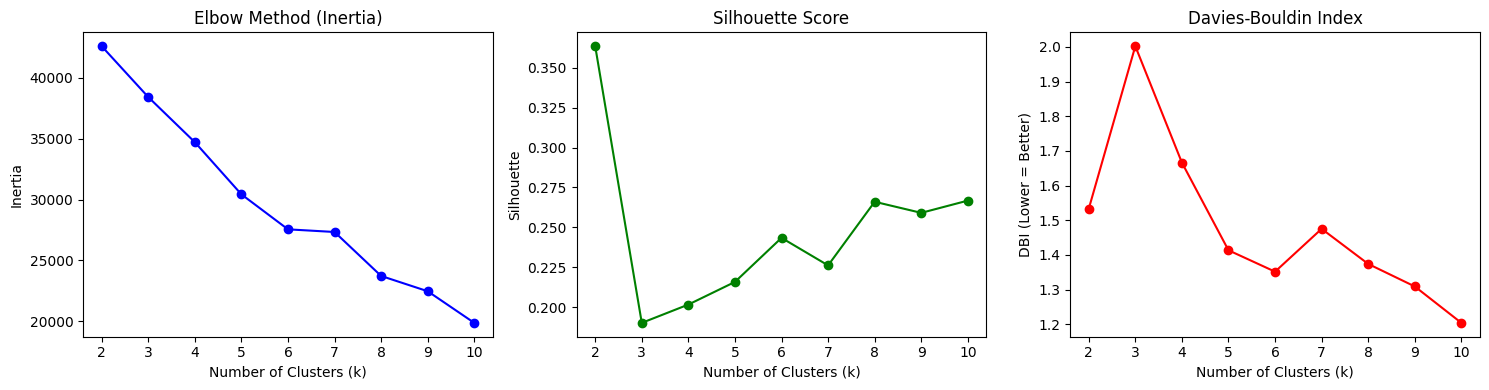

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
silhouette_scores = []
dbi_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    dbi_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot Elbow + Silhouette + DBI
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette')

plt.subplot(1, 3, 3)
plt.plot(K_range, dbi_scores, 'ro-')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI (Lower = Better)')

plt.tight_layout()
plt.show()

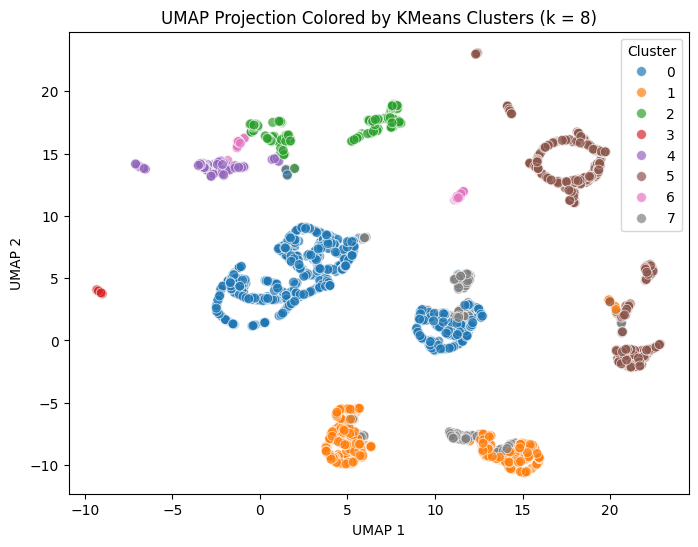

In [ ]:
# Re-run KMeans with final selected k
final_k = 8  # or try 7 as well
kmeans_final = KMeans(n_clusters=final_k, random_state=42)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Visualize clusters on UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster'], palette='tab10', s=50, alpha=0.7)
plt.title(f"UMAP Projection Colored by KMeans Clusters (k = {final_k})")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
df['cluster'].value_counts().sort_index()

,count
cluster,
0,1389
1,840
2,495
3,51
4,244
5,904
6,123
7,378


Cluster Profile Averages:


,admission_grade,success_rate_sem1,age_at_enrollment,scholarship_holder,has_debt,tuition_up_to_date,educational_special_needs,displaced,gender_num,final_situation_num
cluster,,,,,,,,,,
0,127.69,0.76,20.23,0.00,0.00,1.00,0.0,0.68,0.00,1.38
1,126.32,0.60,21.42,0.03,0.00,1.00,0.0,0.54,1.00,1.02
2,124.69,0.40,26.28,0.09,0.47,0.00,0.0,0.44,0.50,0.20
3,124.52,0.67,20.67,0.33,0.12,0.92,1.0,0.57,0.27,1.12
4,127.88,0.68,23.27,0.24,1.00,1.00,0.0,0.46,0.41,0.98
5,127.47,0.89,19.69,1.00,0.00,1.00,0.0,0.65,0.18,1.73
6,125.65,0.59,37.11,0.24,0.17,0.77,0.0,0.12,0.24,0.90
7,127.81,0.65,38.97,0.05,0.00,1.00,0.0,0.14,0.43,1.00


Gender Counts by Cluster:


gender,0,1
cluster,,
0,1389,0
1,0,840
2,249,246
3,37,14
4,145,99
5,739,165
6,93,30
7,216,162


Final Outcome Counts by Cluster:


final_situation,Dropout,Enrolled,Graduate
cluster,,,
0,286,292,811
1,313,201,326
2,426,40,29
3,17,11,23
4,91,67,86
5,72,103,729
6,57,21,45
7,159,59,160


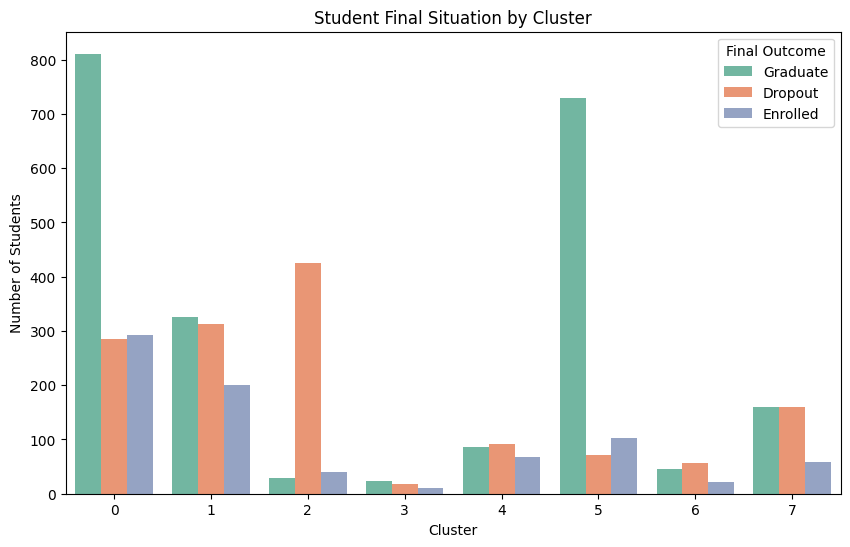

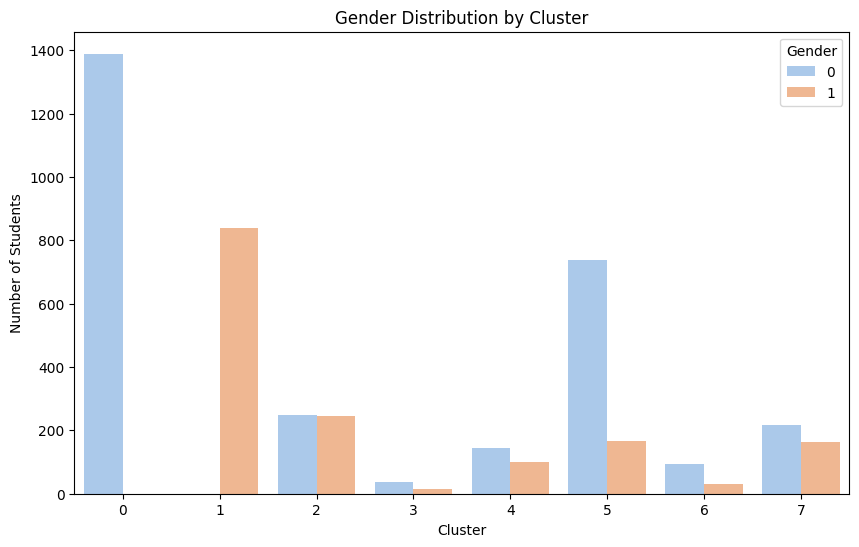

In [ ]:
# F. Cluster Profiling and Summary Export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Features to summarize
profile_cols = [
    'admission_grade', 'success_rate_sem1', 'age_at_enrollment',
    'scholarship_holder', 'has_debt', 'tuition_up_to_date',
    'educational_special_needs', 'displaced'
]

# Encode categorical columns for mean aggregation
df['gender_num'] = df['gender'].astype('category').cat.codes
df['final_situation_num'] = df['final_situation'].astype('category').cat.codes

# Group by cluster and calculate mean of numerical + encoded features
cluster_profiles = df.groupby('cluster')[profile_cols + ['gender_num', 'final_situation_num']].mean().round(2)
print("Cluster Profile Averages:")
display(cluster_profiles)

# Count summaries for categorical variables
cluster_gender_counts = df.groupby(['cluster', 'gender']).size().unstack(fill_value=0)
cluster_outcome_counts = df.groupby(['cluster', 'final_situation']).size().unstack(fill_value=0)

# Display counts
print("Gender Counts by Cluster:")
display(cluster_gender_counts)

print("Final Outcome Counts by Cluster:")
display(cluster_outcome_counts)

# Save all summaries as CSVs for Tableau
cluster_profiles.to_csv("cluster_profiles_avg.csv")  # For numeric features
cluster_gender_counts.to_csv("cluster_gender_counts.csv")  # For gender distribution
cluster_outcome_counts.to_csv("cluster_outcome_counts.csv")  # For final_situation distribution
df.to_csv("full_dataset_with_clusters.csv", index=False)  # For Tableau joining/filtering

# Visualizations (already included — just cleaned up titles slightly)

# Final Situation by Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster', hue='final_situation', palette='Set2')
plt.title('Student Final Situation by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Students')
plt.legend(title='Final Outcome')
plt.show()

# Gender by Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster', hue='gender', palette='pastel')
plt.title('Gender Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Students')
plt.legend(title='Gender')
plt.show()


##F: Cluster Profiling Summary:

Looking at the cluster_profiles table and the visualizations:


- Cluster 0: Has the lowest average age and 100% males. High proportion of graduates.
- Cluster 1: Primarily males, with a good success rate but lower graduation rate than Cluster 0. Slightly older than Cluster 0.
- Cluster 2: Has the highest average age, lowest success rate, and a significant proportion of dropouts. Also has a high proportion of students with debt/tuition issues. More balanced gender distribution than Clusters 0 and 1.
- Cluster 3: Smallest cluster, with a high rate of scholarship holders and educational special needs. Mixed outcomes.
- Cluster 4: Characterized by 100% debt/tuition issues. Mixed gender and age distribution. Lower graduation rate.
- Cluster 5: High success rate and the highest proportion of scholarship holders. Very high graduation rate. Primarily younger students.
- Cluster 6: Older students with a mix of outcomes. Lower proportion of displaced students.
- Cluster 7: Oldest students on average, with a high success rate and good graduation rate. Very low proportion of displaced students.

###**Fairness Analysis Summary:**

The Chi-square tests for independence showed:

- Cluster vs. Gender: There is a statistically significant association between the assigned cluster and gender (p < 0.0001). This means the distribution of genders is not independent across the clusters, suggesting potential gender disparity in the student pathways identified by the clustering.
- Cluster vs. Age Bin: There is a statistically significant association between the assigned cluster and age bin (p < 0.0001). This means the distribution of age groups is not independent across the clusters, suggesting potential age-based disparity in the student pathways.
<br>

###**Overall Interpretation:**

The clustering revealed distinct groups of students with varying academic performance, financial situations, and demographic profiles. The fairness analysis indicates that attributes like gender and age are not evenly distributed across these clusters, suggesting that certain demographic groups may be disproportionately represented in clusters associated with less favorable outcomes (e.g., lower success rates, higher dropout rates) or unique challenges (e.g., debt).

These findings highlight areas where further investigation and potentially targeted interventions may be needed to promote educational equity.

In [ ]:
# G. Fairness Analysis (Chi-square + SHAP)
# Crosstab example:
# pd.crosstab(df['cluster'], df['gender'])
# chi2_contingency(...) to test for overrepresentation
# Optional: SHAP values from DecisionTreeClassifier

In [ ]:
# H. Exporting Results for Tableau
# df.to_csv('students_clustered.csv', index=False)


Performing Chi-square test for Cluster vs. gender
Chi-square statistic: 2481.6826
P-value: 0.0000
Degrees of freedom: 7
Result: Statistically significant association between cluster and gender (reject H0).
Interpretation: The distribution of gender is not independent across clusters, suggesting potential disparity.

Performing Chi-square test for Cluster vs. age_bin
Chi-square statistic: 2884.2985
P-value: 0.0000
Degrees of freedom: 28
Result: Statistically significant association between cluster and age_bin (reject H0).
Interpretation: The distribution of age_bin is not independent across clusters, suggesting potential disparity.

SHAP Summary Plot (Cluster 0 vs others)


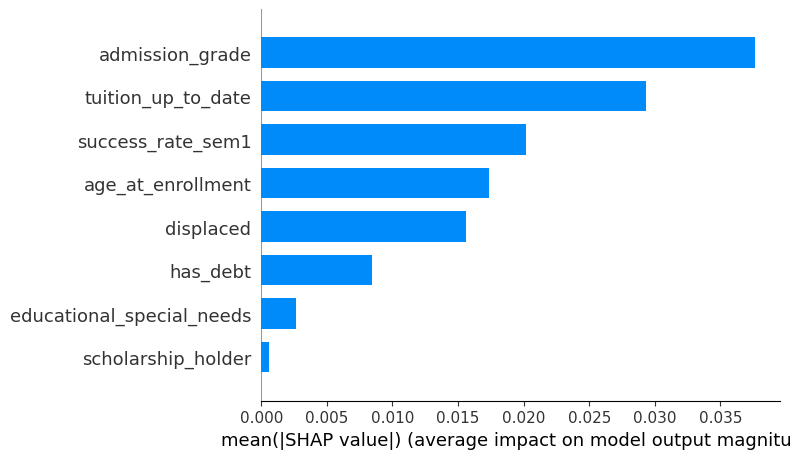

In [ ]:
# G. Fairness Analysis (Chi-square + SHAP)

import pandas as pd
from scipy.stats import chi2_contingency
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# --- Chi-square tests for sensitive attributes ---
sensitive_attributes = ['gender', 'age_bin']
fairness_results = {}

for attribute in sensitive_attributes:
    if attribute in df.columns:
        print(f"\nPerforming Chi-square test for Cluster vs. {attribute}")
        contingency_table = pd.crosstab(df['cluster'], df[attribute])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        fairness_results[attribute] = {
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof
        }

        print(f"Chi-square statistic: {chi2:.4f}")
        print(f"P-value: {p:.4f}")
        print(f"Degrees of freedom: {dof}")

        if p < 0.05:
            print(f"Result: Statistically significant association between cluster and {attribute} (reject H0).")
            print(f"Interpretation: The distribution of {attribute} is not independent across clusters, suggesting potential disparity.")
        else:
            print(f"Result: No statistically significant association (fail to reject H0).")
    else:
        print(f"\nWarning: Sensitive attribute '{attribute}' not found in the dataframe.")

# --- Optional: SHAP Explanation of Cluster Assignment ---
# Encode categorical variables for DecisionTreeClassifier
X = df[profile_cols].copy()
y = df['cluster']

# Fit a decision tree classifier for interpretability
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# SHAP values to explain clustering
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot for one class (e.g., cluster 0)
print("\nSHAP Summary Plot (Cluster 0 vs others)")
shap.summary_plot(shap_values[0], X, plot_type="bar")


##G. Fairness Analysis
**1. Chi-Square Tests of Independence**

To assess the fairness of the clustering results with respect to sensitive attributes, we performed Chi-square tests of independence between the cluster variable and two key demographic features: gender and age_bin.

- Cluster vs. Gender

   - Chi-square statistic: 2481.68

   - p-value: < 0.0001

   - Interpretation: There is a statistically significant association between cluster assignment and gender. This suggests that the gender distribution is not independent across clusters, indicating potential gender disparity in the clustering results.

- Cluster vs. Age Bin

   - Chi-square statistic: 2884.30

   - p-value: < 0.0001

   - Interpretation: Similarly, we observe a statistically significant association between cluster assignment and age group. The age distribution varies across clusters in a way that is unlikely to be due to chance, indicating age-based disparity in the learned clusters.

These findings highlight that the clustering model has implicitly captured demographic differences, which may reflect or reinforce existing structural inequities. This necessitates cautious interpretation and possibly targeted policy interventions to ensure equitable outcomes.

**2. SHAP Values: Cluster 0 vs Others**

To better understand the key features that distinguish Cluster 0 (which had 100% male students and a high graduation rate), we trained a Decision Tree Classifier to predict Cluster 0 membership and applied SHAP (SHapley Additive exPlanations) values to interpret the model.

The SHAP summary plot shows the top features influencing classification into Cluster 0:

- admission_grade had the highest impact, indicating that students in Cluster 0 typically had strong academic records at admission.

- tuition_up_to_date and success_rate_sem1 were also strong positive indicators, suggesting these students had financial stability and early academic success.

- age_at_enrollment and displaced followed, with lower age and non-displacement contributing positively to Cluster 0 membership.

- has_debt, educational_special_needs, and scholarship_holder were negative contributors, meaning students in Cluster 0 typically lacked these risk factors.

These insights confirm that Cluster 0 represents a privileged academic subgroup with strong academic preparation, financial stability, and fewer barriers. This sharp contrast with other clusters—particularly those with overrepresentation of debt, special needs, or older students—raises fairness concerns that should be addressed through equity-aware educational interventions.

In [ ]:
# H. Exporting Results for Tableau

# Full student data with cluster labels
df.to_csv("students_clustered.csv", index=False)

# Export key summaries for Tableau
cluster_profiles.to_csv("cluster_profiles_avg.csv")
cluster_gender_counts.to_csv("cluster_gender_counts.csv")
cluster_outcome_counts.to_csv("cluster_outcome_counts.csv")

# Optional: Export fairness chi-square results
fairness_df = pd.DataFrame(fairness_results).T
fairness_df.to_csv("fairness_chi_square_results.csv")

# Save full dataset with cluster labels
df.to_csv('students_clustered.csv', index=False)

# Export the summarized cluster profiles separately
cluster_profiles.to_csv('cluster_profiles_summary.csv')


print("All exports complete and ready for Tableau.")

All exports complete and ready for Tableau.


##H. Exporting Results for Tableau
To enable further interactive analysis and dashboard creation in Tableau, we exported the processed dataset with all relevant information, including:

- Cluster labels

- Original student features (e.g., age, gender, admission grades)

- Outcome variables (e.g., final situation)

- Sensitive attributes (e.g., gender, age bin)

- Derived columns (e.g., success rates, financial flags)

This export supports:

- Cluster profiling: enabling comparison across student pathways.

- Fairness auditing: tracking how gender, age, and other attributes relate to educational outcomes.

- Actionable insights: identifying student subgroups needing support.